### script to extract results from log.txt file

# emcee

## all params

### J included in the MCMC scan alongside the nuisance parameters

## coverage 

In [1]:
from os import listdir
import numpy as np
import pylab as plt

from scipy.interpolate import interp1d as interp
from scipy.optimize import brentq

%matplotlib inline

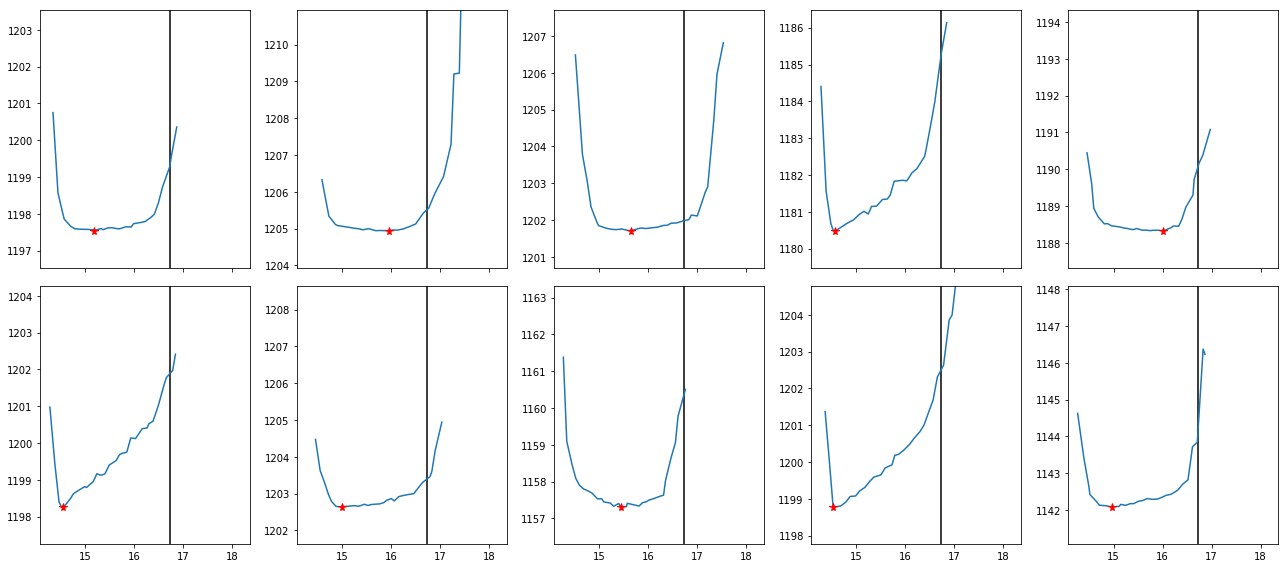

In [21]:
Jtrue = 16.72
path = '../results/mcmc/cov/'

S=1000
samples_list = sorted([f for f in listdir(path) if 'samples_cov%i_'%S in f])
lnprobs_list = sorted([f for f in listdir(path) if 'lnprobs_cov%i_'%S in f])

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(18,8) )

Jmins = []
in1s,in2s,in3s = 0,0,0
for j,( (samples, lnprobs), ax) in enumerate( zip( zip(samples_list[:10], lnprobs_list[:10]), axes.flat) ):
    try:
        samples = np.load(path+samples)
        lnprobs = np.load(path+lnprobs)
    except:
        continue
    
    Jmc = samples[:,0]
    Lmc = -lnprobs
    Lmin = min(Lmc)
    
    Jenv, Lenv = [], []

    hist, binsedges = np.histogram(Jmc, bins=30)
    for Jl,Jr in zip( binsedges[:-1], binsedges[1:] ):
        indbin = np.where( np.logical_and( Jl<Jmc, Jmc<Jr ) )[0]
        if any(indbin):
            Lbin, Jbin = Lmc[indbin], Jmc[indbin]
            indLmin = np.where( Lbin==min(Lbin) )[0][0]
            Jenv.append( Jbin[indLmin] )
            Lenv.append( Lbin[indLmin] )
    
    interpLenv = interp(Jenv, Lenv)
    eval_Like_J = np.linspace(min(Jenv), max(Jenv), 100)
    min_Like_J = min(interpLenv(eval_Like_J))
    Jmin = eval_Like_J[ np.where( interpLenv(eval_Like_J) == min_Like_J )[0][0] ]
    Jmins.append( Jmin )
    
    ax.plot(Jenv, interpLenv(Jenv));
    ax.plot(Jmin, Lmin, 'r*', ms=8);
    ax.set_ylim(Lmin-1, Lmin+6);
    ax.vlines(Jtrue, Lmin-1, Lmin+6);
    '''for i,c in enumerate([0.5, 2.0, 4.5]):
        try:
            exec('J%ssL = %.2f'%(i+1, brentq(lambda j : interpLenv(j)-min_Like_J-c, min(Jenv), Jmin) - Jmin))
            exec('J%ssR = %.2f'%(i+1, brentq(lambda j : interpLenv(j)-min_Like_J-c, Jmin, max(Jenv)) - Jmin))
        except:
            pass
    
    if Jmin+J1sL < Jtrue < Jmin+J1sR: in1s +=1 
    if Jmin+J2sL < Jtrue < Jmin+J2sR: in2s +=1 
    #if Jmin+J3sL < Jtrue < Jmin+J3sR: in3s +=1 
Jmins = np.asarray( Jmins )
relbias = (Jtrue-Jmins.mean())/Jtrue'''
plt.tight_layout()
#plt.savefig('../results/mcmc/some_cov1000.png', dpi=300);

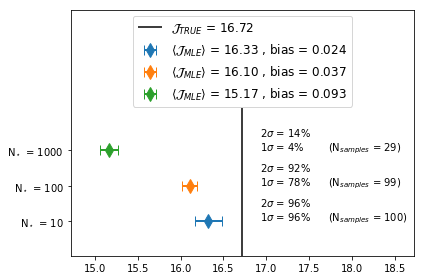

In [117]:
Jtrue = 16.72
path = '../results/mcmc/cov/'
sizes = [10, 100, 1000]
for s,S in enumerate( sizes ):
    samples_list = sorted([f for f in listdir(path) if 'samples_cov%i_'%S in f])
    lnprobs_list = sorted([f for f in listdir(path) if 'lnprobs_cov%i_'%S in f])
    
    Jmins = []
    in1s,in2s,in3s = 0,0,0
    for j,(samples, lnprobs) in enumerate( zip(samples_list, lnprobs_list) ):
        try:
            samples = np.load(path+samples)
            lnprobs = np.load(path+lnprobs)
        except:
            continue
        
        Jmc = samples[:,0]
        Lmc = -lnprobs
        Lmin = min(Lmc)
        
        Jenv, Lenv = [], []

        hist, binsedges = np.histogram(Jmc, bins=30)
        for Jl,Jr in zip( binsedges[:-1], binsedges[1:] ):
            indbin = np.where( np.logical_and( Jl<Jmc, Jmc<Jr ) )[0]
            if any(indbin):
                Lbin, Jbin = Lmc[indbin], Jmc[indbin]
                indLmin = np.where( Lbin==min(Lbin) )[0][0]
                Jenv.append( Jbin[indLmin] )
                Lenv.append( Lbin[indLmin] )
        
        interpLenv = interp(Jenv, Lenv)
        eval_Like_J = np.linspace(min(Jenv), max(Jenv), 100)
        min_Like_J = min(interpLenv(eval_Like_J))
        Jmin = eval_Like_J[ np.where( interpLenv(eval_Like_J) == min_Like_J )[0][0] ]
        Jmins.append( Jmin )
        
        for i,c in enumerate([0.5, 2.0, 4.5]):
            try:
                exec('J%ssL = %.2f'%(i+1, brentq(lambda j : interpLenv(j)-min_Like_J-c, min(Jenv), Jmin) - Jmin))
                exec('J%ssR = %.2f'%(i+1, brentq(lambda j : interpLenv(j)-min_Like_J-c, Jmin, max(Jenv)) - Jmin))
            except:
                pass
        
        if Jmin+J1sL < Jtrue < Jmin+J1sR: in1s +=1 
        if Jmin+J2sL < Jtrue < Jmin+J2sR: in2s +=1 
        #if Jmin+J3sL < Jtrue < Jmin+J3sR: in3s +=1 
    Jmins = np.asarray( Jmins )

    relbias = (Jtrue-Jmins.mean())/Jtrue
    plt.errorbar(x=Jmins.mean(), 
                 y=s+1, 
                 xerr=Jmins.std()/np.sqrt(Jmins.size),
                 linestyle='', 
                 marker='d', 
                 markersize=10, 
                 linewidth=2, 
                 capsize=5, 
                 label=r'$\left<\mathcal{J}_{MLE}\right>$ = %.2f'%Jmins.mean() + ' , bias = %.3f'%relbias);
    plt.text(s="2$\sigma$ = %i"%in2s + '%' + "\n" + r"1$\sigma$ = %i"%in1s + '%', 
            x=Jtrue+0.2,
            y=s+1);
    plt.text(s=r"(N$_{samples}$ = %i)"%len(lnprobs_list), 
            x=Jtrue+1,
            y=s+1);

plt.vlines(x=Jtrue, ymin=0, ymax=4.2, label=r'$\mathcal{J}_{TRUE}$ = 16.72');
plt.yticks(range(1,4),[r'N$_\star$ = %i'%s for s in sizes]);
plt.xlim(Jtrue-2, Jtrue+2);
plt.ylim(0, 7);
plt.legend(fontsize=12, loc='upper center').set_zorder(100);
plt.tight_layout();
#plt.savefig('../results/mcmc/bias.png', dpi=300);

plt.plot(Jmc, Lmc, 'bo', label='MCMC scan points');
plt.plot(Jenv, Lenv, 'c', lw=3, label='MCMC envelope');
plt.xlim(10, 30);
plt.ylim(Lmin-1, Lmin+10);
plt.legend();
plt.suptitle('profile-vs-mcmc', fontsize=14);
#plt.savefig(path + 'profile-vs-mcmc.png', dpi=300);

## manual coverage

In [36]:
from os import listdir
import numpy as np
import pylab as plt

from scipy.interpolate import interp1d as interp
from scipy.optimize import brentq

%matplotlib inline

In [37]:
results = np.load('../results/mcmc/cov/manu_cov10_n100.npy')
results[0]

array([  1.21552150e+01,   1.73983856e+01,  -8.70613146e-01,
         3.98241649e+00,   7.23333715e+00,   5.05792540e-04])

In [38]:
J_array = results[:,0]
Likes = results[:,1]
params = results[:,1:]

Lmin_man = min(Likes)
indLmin = np.where( Likes==Lmin_man )[0][0]
Jmin_man = J_array[ indLmin ]

In [39]:
samples = np.load('../results/mcmc/cov/samples_cov10_n100.npy')
lnprobs = np.load('../results/mcmc/cov/lnprobs_cov10_n100.npy')

In [42]:
Jmc = samples[:,0]
Lmc = -lnprobs
Lmin_mc = min(Lmc)

Jenv, Lenv = [], []

hist, binsedges = np.histogram(Jmc, bins=30)
for Jl,Jr in zip( binsedges[:-1], binsedges[1:] ):
    indbin = np.where( np.logical_and( Jl<Jmc, Jmc<Jr ) )[0]
    if any(indbin):
        Lbin, Jbin = Lmc[indbin], Jmc[indbin]
        indLmin = np.where( Lbin==min(Lbin) )[0][0]
        Jenv.append( Jbin[indLmin] )
        Lenv.append( Lbin[indLmin] )
        
interpLenv = interp(Jenv, Lenv)
eval_Like_J = np.linspace(min(Jenv), max(Jenv), 100)
min_Like_J = min(interpLenv(eval_Like_J))
Jmin_mc = eval_Like_J[ np.where( interpLenv(eval_Like_J) == min_Like_J )[0][0] ]

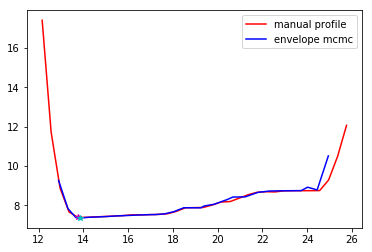

In [47]:
#plt.plot(Jmc, Lmc, 'bo', alpha=0.5);
plt.plot(J_array, Likes, 'r-', label='manual profile');
plt.plot(Jenv, interpLenv(Jenv), 'b-', label='envelope mcmc');
plt.plot(Jmin_man, Lmin_man, 'm*', Jmin_mc, Lmin_mc, 'c*');
plt.legend();

In [66]:
Jtrue = 16.72
path = '../results/mcmc/cov/'

S=10
manu_list = sorted([f for f in listdir(path) if 'manu_cov%i_n'%S in f])

Jmins = []
in1s,in2s,in3s = 0,0,0
for j,samples in enumerate( manu_list ):
    results = np.load(path+samples)
    
    J_array = results[:,0]
    Likes = results[:,1]
    params = results[:,1:]

    Lmin_man = min(Likes)
    indLmin = np.where( Likes==Lmin_man )[0][0]
    Jmin_man = J_array[ indLmin ]
    
    Jmins.append( Jmin_man )
Jmins = np.array(Jmins)

### convergence check with Gelman-Rubin criterion for coverage/bias tests results

### 2D histogram of peak

## test convergence - via Geman-Rubin criteria - as a function of Nsteps

For  
- N$_\star$ = 10, $\sim$ 1000 steps in the chain suffice
- N$_\star$ = 100, $\sim$ 2000 steps it's a better choice
- N$_\star$ = 712, $\sim$ 3000 steps should suffice to given $R\approx1$

## plot all plots for all Js

## build profile

# brute force

## L - r , a

# PyMC

## determination of smoothing order via Leave-one-out cross-validation

# Minuit